This notebook aims to check whether the lightning NO2 is included in the TM5 NO2 profile (at least above the cloud pressure).

According to the ATBD, the TM5 model only assimilates the slant column densities.

![OFFL](./imgs/OFFL_processing.png)

> For OFFL the processing starts with the DOAS spectral fits and derivation of the slant columns (red box).
>
> These are stored in preliminary NO2 L2 files and read by the TM5-MP chemistry-transport model.
>
> The air-mass factors, averaging kernels and vertical columns are computed in a retrieval module which is part of TM5-MP, using the model fields co-located in space and time to the measurement time and footprint.
> 
> After the retrieval step the NO2 total slant columns are assimilated in TM5-MP.
> 
> The result of this step is a stratospheric column which is in good agreement with the TROPOMI data.

In [1]:
import numpy as np
import proplot as pplt
from satpy import Scene
from glob import glob
import xarray as xr

pplt.rc['cmap'] = 'viridis'
pplt.rc.update({'meta.width': 0.6, 'label.weight': 'bold', 'tick.labelweight': 'normal'})

In [2]:
def load_tropomi(filename):
    """Load TROPOMI NO2 L2 products by satpy"""
    scn = Scene(filename, reader='tropomi_l2')
    vnames = ['cloud_radiance_fraction_nitrogendioxide_window', 'cloud_pressure_crb',
              'assembled_lat_bounds', 'assembled_lon_bounds',
              'longitude', 'latitude',
              'tm5_constant_a', 'tm5_constant_b', 'surface_pressure',
              'averaging_kernel', 'air_mass_factor_troposphere', 'air_mass_factor_clear', 'air_mass_factor_cloudy',
              'oxygen_oxygen_dimer_slant_column_density',
              'nitrogendioxide_ghost_column', 'nitrogendioxide_tropospheric_column',
              'nitrogendioxide_slant_column_density', 'nitrogendioxide_stratospheric_column', 'air_mass_factor_stratosphere',
              'solar_zenith_angle', 'viewing_zenith_angle']

    if 'no2_vmr' in scn.available_dataset_names():
        vnames.append('no2_vmr')
        scn.load(vnames)
        scn['no2_vmr'] = scn['no2_vmr'].assign_coords({'longitude': scn['nitrogendioxide_tropospheric_column'].longitude})
    else:
        scn.load(vnames)

    scn['SCD_Strato'] = scn['nitrogendioxide_stratospheric_column'] * scn['air_mass_factor_stratosphere']
    scn['SCD_Trop'] = scn['nitrogendioxide_slant_column_density'] - scn['SCD_Strato']

    scn['SCD_Strato'] = scn['SCD_Strato'].rename('SCD_Strato')
    scn['SCD_Trop'] = scn['SCD_Trop'].rename('SCD_Trop')
    scn['SCD_Strato'].attrs['units'] = 'mol m-2'
    scn['SCD_Trop'].attrs['units'] = 'mol m-2'

    # calculate pressure levels
    a = scn['tm5_constant_a']
    b = scn['tm5_constant_b']
    psfc = scn['surface_pressure']

    low_p = (a[:, 0] + b[:, 0]*psfc)/1e2
    high_p = (a[:, 1] + b[:, 1]*psfc)/1e2

    scn['p'] = xr.concat([low_p, high_p.isel(layer=-1)], dim='layer')
    scn['p'] = scn['p'].rolling({'layer': 2}).mean()[1:, ...].load()
    scn['p'] = scn['p'].rename('tm5_pressure')
    scn['p'].attrs['units'] = 'hPa'

    # assign lon/lat coords
    scn['p'] = scn['p'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['solar_zenith_angle'] = scn['solar_zenith_angle'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['air_mass_factor_clear'] = scn['air_mass_factor_clear'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['air_mass_factor_cloudy'] = scn['air_mass_factor_cloudy'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['nitrogendioxide_slant_column_density'] = scn['nitrogendioxide_slant_column_density'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['viewing_zenith_angle'] = scn['viewing_zenith_angle'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['oxygen_oxygen_dimer_slant_column_density'] = scn['oxygen_oxygen_dimer_slant_column_density'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )

    return scn

In [3]:
def get_scn(f_pre, f_ltng, f_post):
    scn_ltng_pre = load_tropomi(f_pre)
    scn_ltng = load_tropomi(f_ltng)
    scn_ltng_post = load_tropomi(f_post)

    return scn_ltng_pre, scn_ltng, scn_ltng_post

In [26]:
def mask_scn(scn, lon_min, lon_max, lat_min, lat_max):
    """mask the Scene to the lightning NO2 region"""
    mask = (scn['longitude'] >= lon_min) & \
           (scn['longitude'] <= lon_max) & \
           (scn['latitude'] >= lat_min) & \
           (scn['latitude'] <=lat_max)

    return scn['SCD_Strato'].where(mask, drop=True), \
           scn['SCD_Trop'].where(mask, drop=True), \
           scn['nitrogendioxide_tropospheric_column'].where(mask, drop=True), \
           scn['no2_vmr'].where(mask, drop=True) ,\
           scn['p'].where(mask, drop=True)

In [27]:
def plot_no2(scn_list, lon_min, lon_max, lat_min, lat_max):
    fig, axs = pplt.subplots(nrows=3, ncols=3)

    for index,scn in enumerate(scn_list):
        scd_strato, scd_trop, vcd_trop, _, _ = mask_scn(scn, lon_min, lon_max, lat_min, lat_max)

        scd_strato.plot(
                    x='longitude', y='latitude', ax=axs[index*3],
                    cmap='Thermal', vmin=2.5e-4, vmax=4e-4, discrete=False,
                    )

        scd_trop.plot(
                    x='longitude', y='latitude', ax=axs[index*3+1],
                    cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-4.5e-5, vmax=4.5e-5, discrete=False,
                    )

        vcd_trop.plot(
                    x='longitude', y='latitude', ax=axs[index*3+2],
                    cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-3e-5, vmax=3e-5,  discrete=False,
                    )

        if index == 1:
            print(vcd_trop.argmax().load())

    axs.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max),
               xlabel='Longitude', ylabel='Latitude', title='',
               toplabels=['SCD_Strato', 'SCD_Trop', 'VCD_Trop'],
               leftlabels=['one day before',
                           'lightning day',
                           'one day after'],
               facecolor='Gray'
               )
    

## Case 1: 2019-08-09

In [ ]:
f_pre = glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190809T21*.nc')
f_ltng = glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190810T21*.nc')
f_post = glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190811T21*.nc')

scn_ltng_pre, scn_ltng, scn_ltng_post = get_scn(f_pre, f_ltng, f_post)

### 2D distribution of TROPOMI data

<xarray.DataArray 'nitrogendioxide_tropospheric_column' ()>
array(8419)
Coordinates:
    time     datetime64[ns] 2019-08-10
    crs      object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs


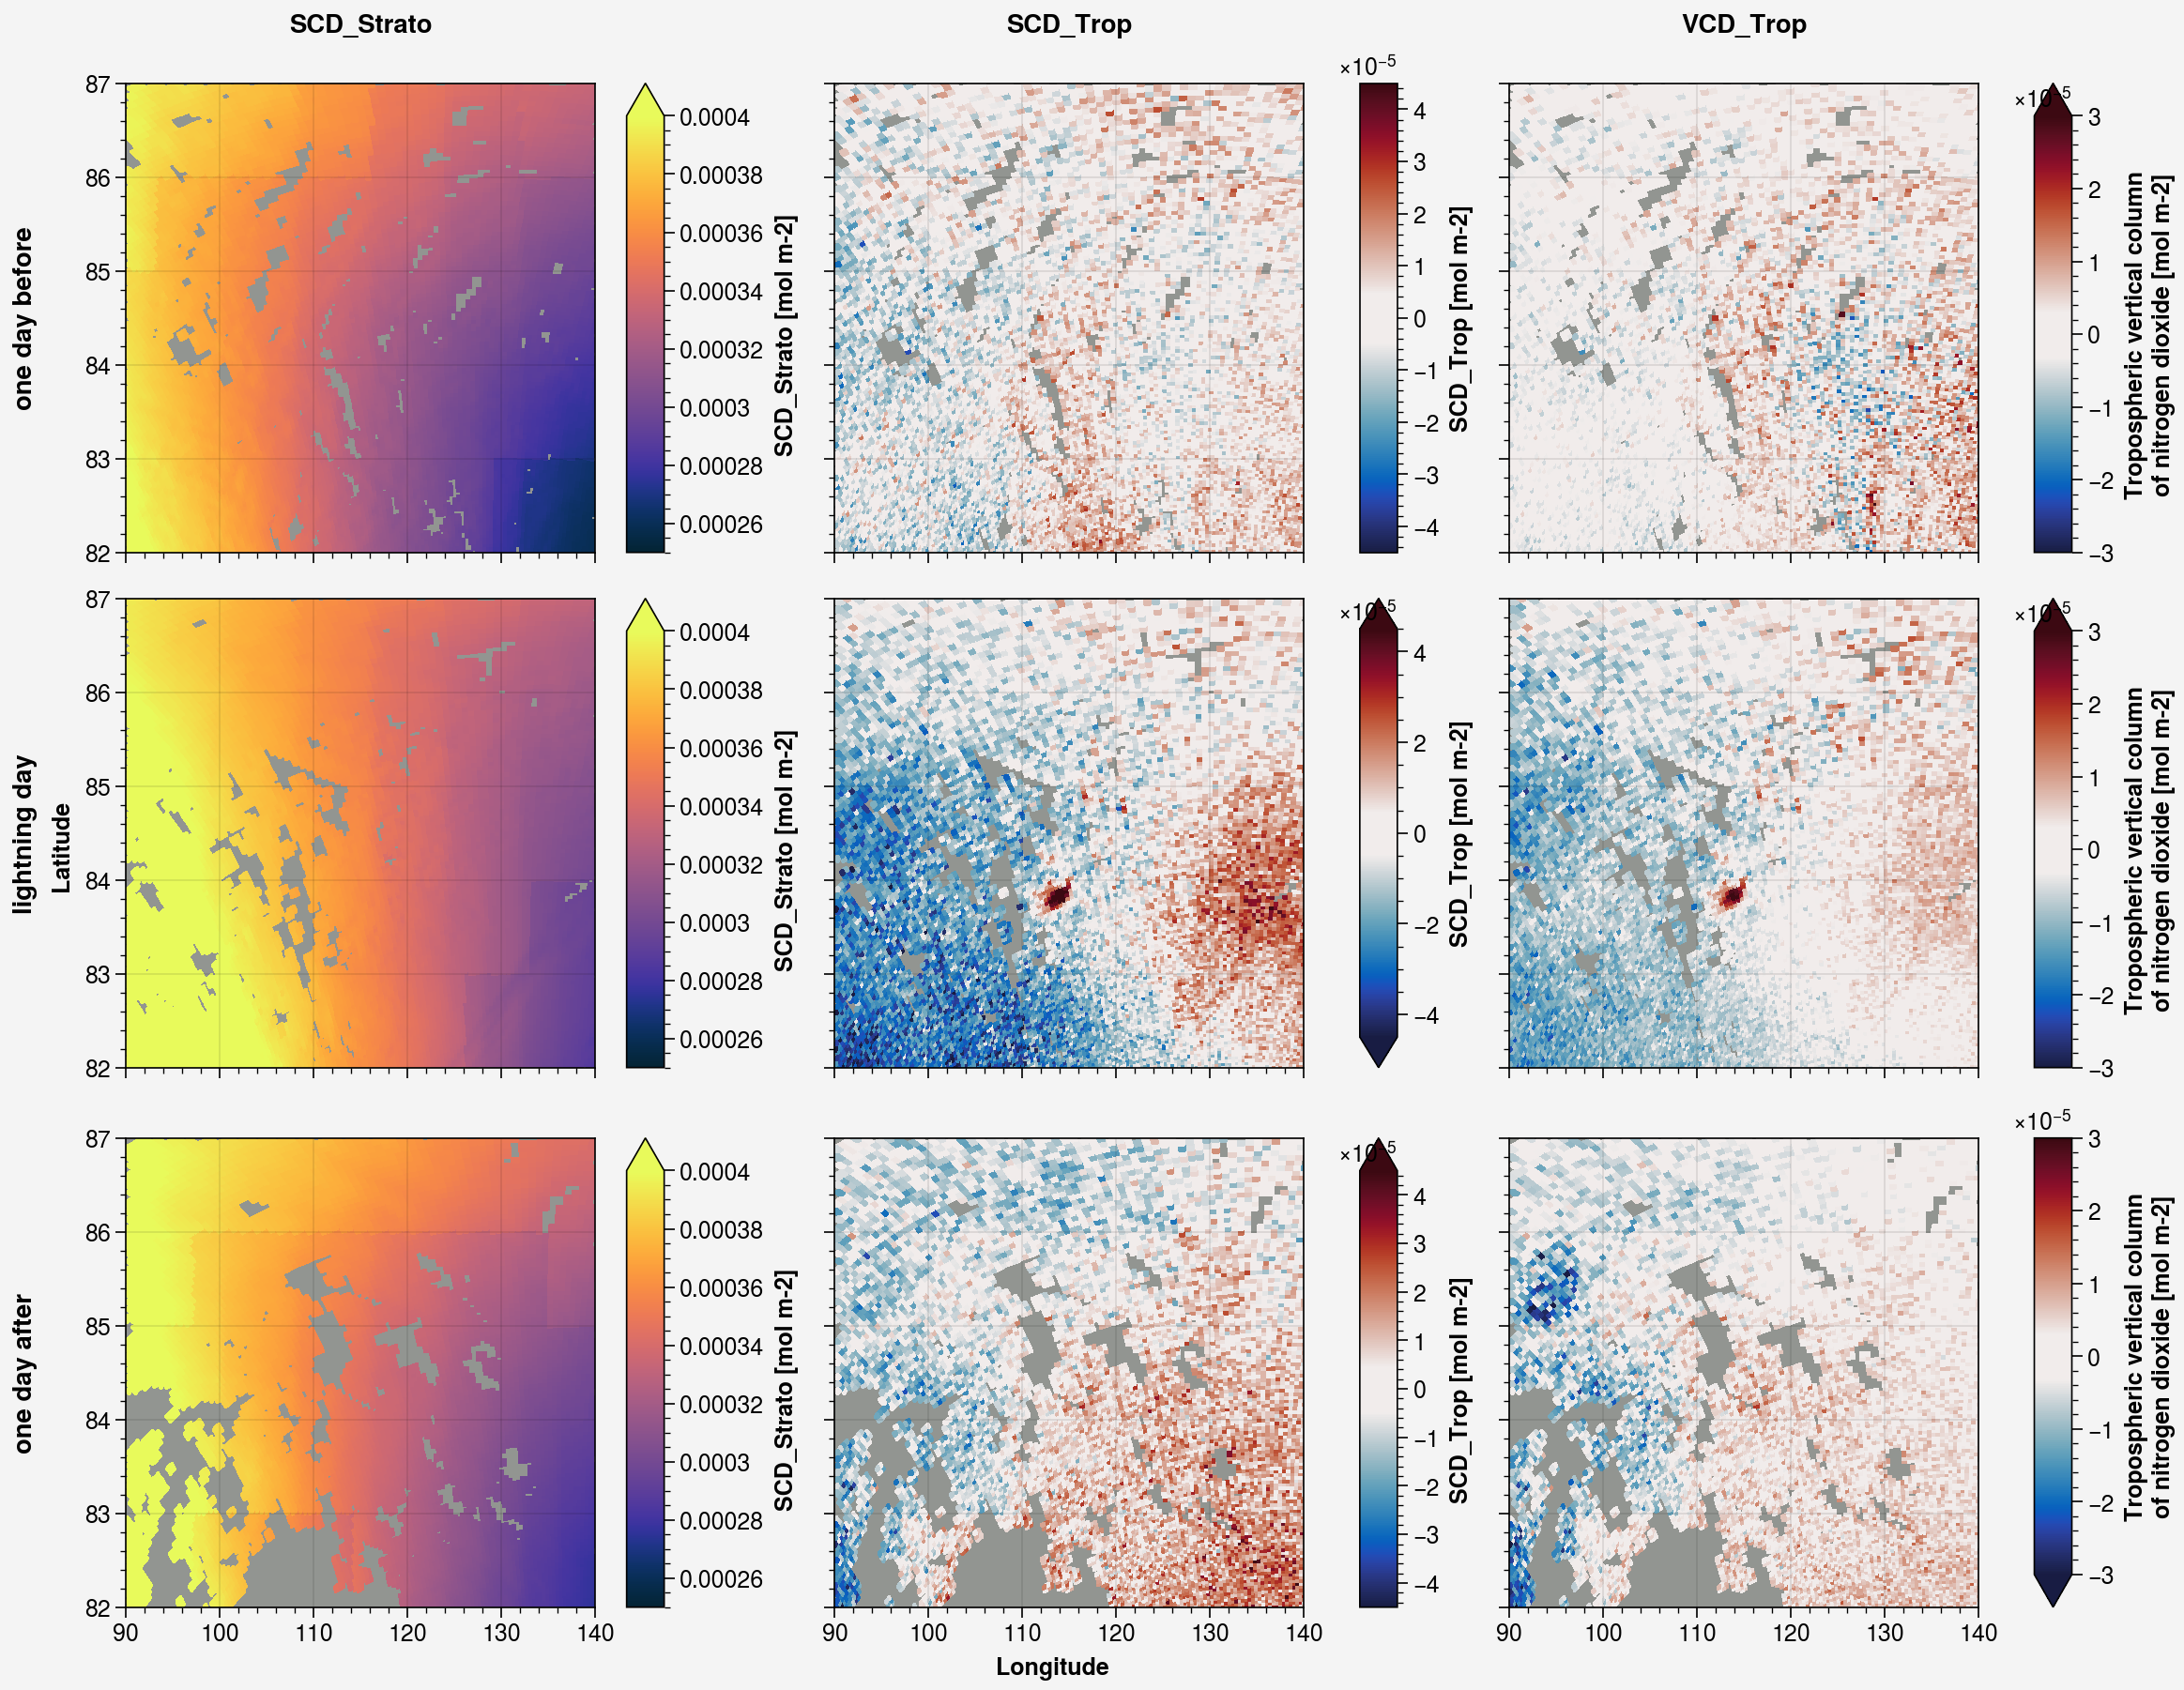

In [18]:
plot_no2([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min=90, lon_max=140, lat_min=82, lat_max=87)

## Mean NO2 profile over the lightning NO2 region

In [30]:
def plot_no2_profile(scn_list, lon_min, lon_max, lat_min, lat_max):
    # fig, axs = pplt.subplots(nrows=3, ncols=3)

    _, _, _, no2_pre, pressure_pre = mask_scn(scn_list[0], lon_min, lon_max, lat_min, lat_max)
    no2_pre = no2_pre.mean(['x', 'y'])
    pressure_pre = pressure_pre.mean(['x', 'y'])

    _, _, _, no2_ltng, pressure_ltng = mask_scn(scn_list[1], lon_min, lon_max, lat_min, lat_max)
    no2_ltng = no2_ltng.mean(['x', 'y'])
    pressure_ltng = pressure_ltng.mean(['x', 'y'])

    _, _, _, no2_post, pressure_post = mask_scn(scn_list[2], lon_min, lon_max, lat_min, lat_max)
    no2_post = no2_post.mean(['x', 'y'])
    pressure_post = pressure_post.mean(['x', 'y'])

    fig, axs = pplt.subplots()

    l_ltng = axs.plot(no2_ltng*1e12, pressure_ltng, label='lightning')
    l_noltng_before = axs.plot(no2_pre*1e12, pressure_pre, label='no lightning (one day before)')
    l_noltng_after = axs.plot(no2_post*1e12, pressure_post, label='no lightning (one day after)')


    axs.legend([l_noltng_before, l_ltng, l_noltng_after], loc='r', ncols=1)
    axs.format(xlabel='TM5 a priori NO2 (pptv)', ylabel='Pressure (hPa)', ylim=(1000, 100), xlim=(0, 200))

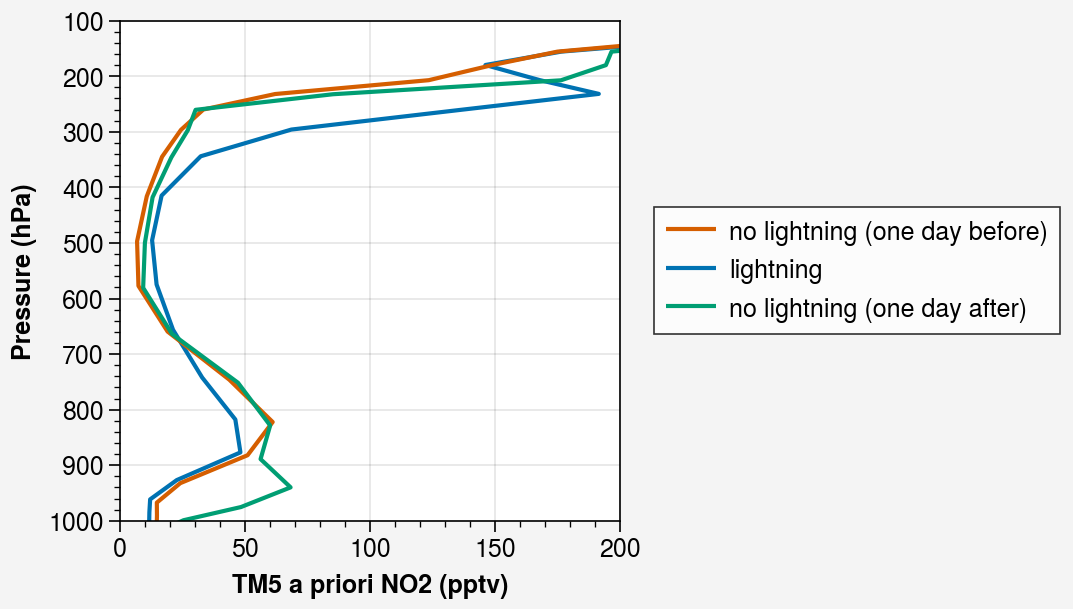

In [31]:
plot_no2_profile([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min=113, lon_max=114, lat_min=83.8, lat_max=83.9)

### a priori NO2 at ~ 345 hPa

In [42]:
def plot_no2_plev(scn_list, lon_min, lon_max, lat_min, lat_max):
    # fig, axs = pplt.subplots(nrows=3, ncols=3)

    _, _, _, no2_pre, pressure_pre = mask_scn(scn_list[0], lon_min, lon_max, lat_min, lat_max)
    no2_pre = no2_pre.isel(layer=11)

    _, _, _, no2_ltng, pressure_ltng = mask_scn(scn_list[1], lon_min, lon_max, lat_min, lat_max)
    no2_ltng = no2_ltng.isel(layer=11)

    _, _, _, no2_post, pressure_post = mask_scn(scn_list[2], lon_min, lon_max, lat_min, lat_max)
    no2_post = no2_post.isel(layer=11)

    fig, axs = pplt.subplots(ncols=3)

    no2_pre.plot(ax=axs[0], x='longitude', y='latitude', vmin=0, vmax=5e-11, discrete=False)
    no2_ltng.plot(ax=axs[1], x='longitude', y='latitude', vmin=0, vmax=5e-11, discrete=False)
    no2_post.plot(ax=axs[2], x='longitude', y='latitude', vmin=0, vmax=5e-11, discrete=False)

    axs.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max),
               xlabel='Longitude', ylabel='Latitude',
               title=['', '', ''],
               toplabels=['one day before',
                           'lightning day',
                           'one day after'],
               facecolor='Gray',
               )

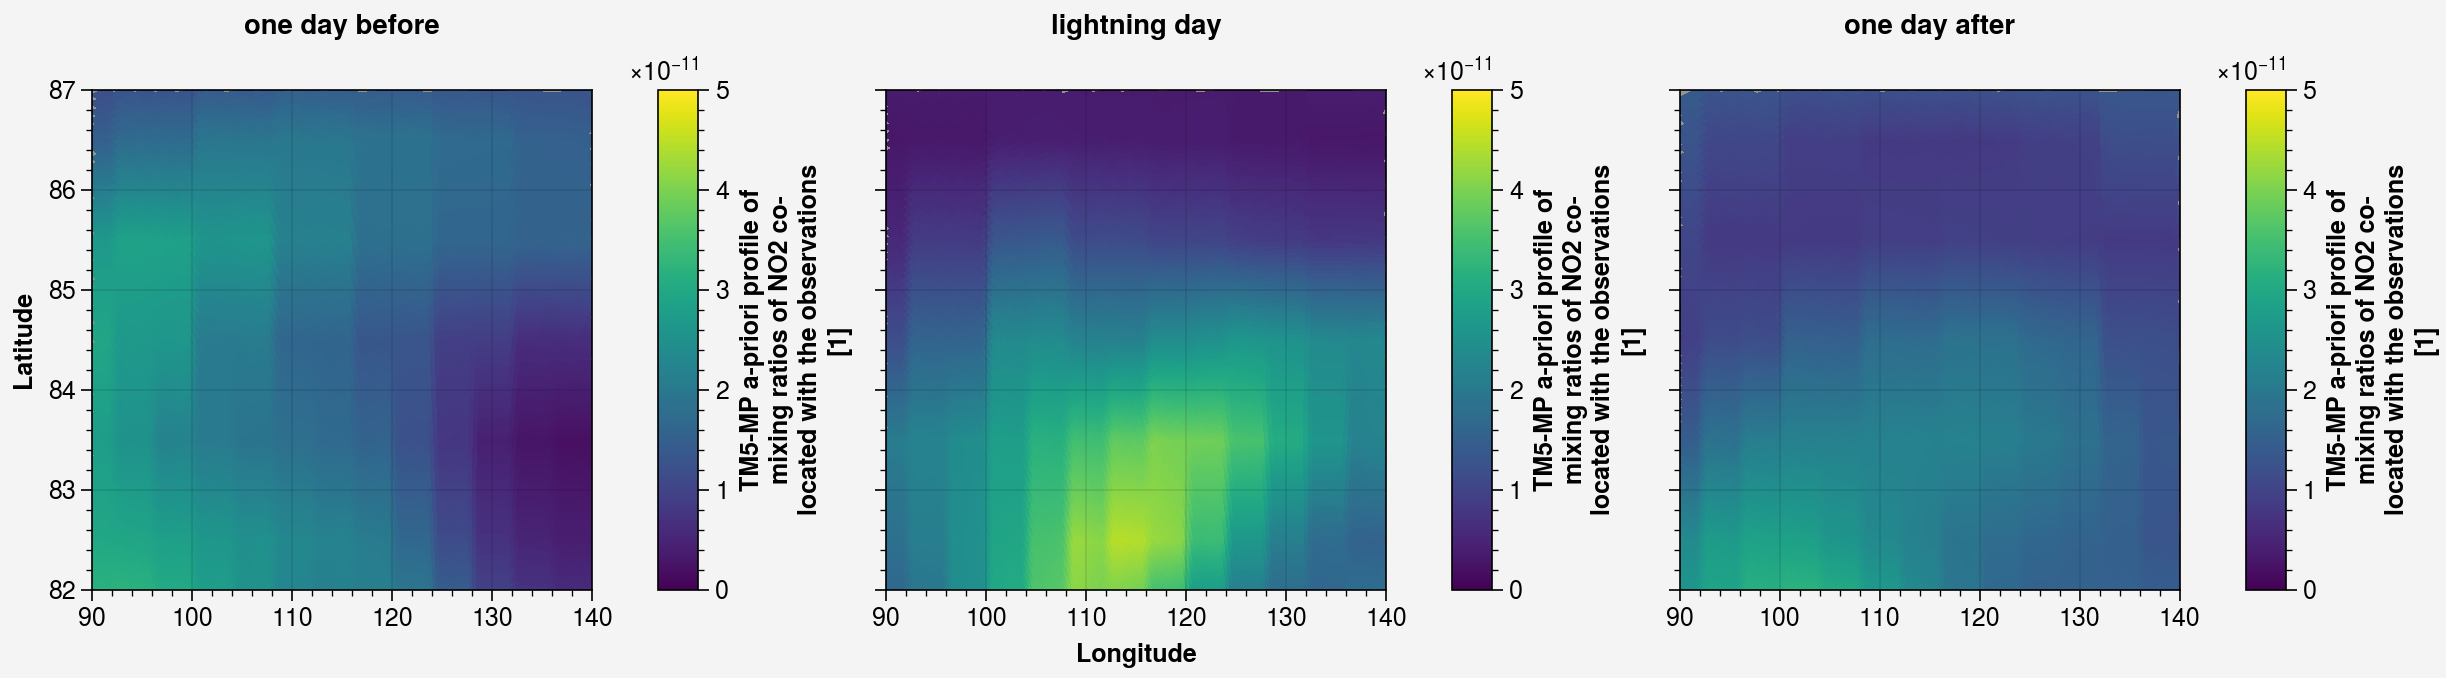

In [43]:
plot_no2_plev([scn_ltng_pre, scn_ltng, scn_ltng_post], lon_min=90, lon_max=140, lat_min=82, lat_max=87)